# Bayesian A/B Testing

## Methodology

Given some data, the bayesian procedure can be outlined with the following steps [1]:  
1) Identify out prior distribution (gaussian, poisson, beta, etc.), this expresses our initial understanding of a parameter (ῦ for example) prior to seeing any data  
2) Choose a statistical model (Markov chains, bayesian bandits, etc.) which reflects our beliefs about x given ῦ  
3) After observing some data, update our beliefs and calculate the posterior distribution p(ῦ | x). The posterior distribution is a probability distribution which portrays your updated beliefs about your parameter after observing the data.  

As you can imagine, the larger the number of observations (N), the better the approximation of your posterior distribution. However, if your number of observations is too large, you’re losing a lot of impressions which could generate revenue for your website. For example, if you were running an A/B test for your website to identify which (of two) landing pages yields a very high click through rate, then the more samples you do, the more people you’re exposing to a landing page which would decrease the clicks the number of clicks you would have potentially gotten. Thus, having a sample size which is not too large and not too small is ideal.  

## Explore Exploit Dilema 

In reinforcement learning, when an agent gathers information through assessing the scenario which may lead to a positive outcome is known as exploration. After exploration, one learns the optimal decisions with the highest possible outcome given the current known information is called exploitation. It’s best to balance exploitation, and exploitation.  

## Example 1

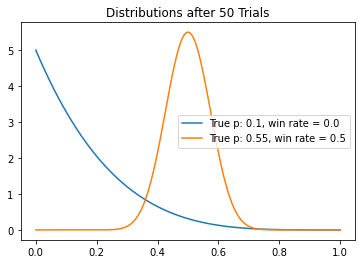

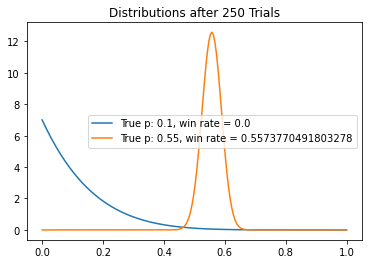

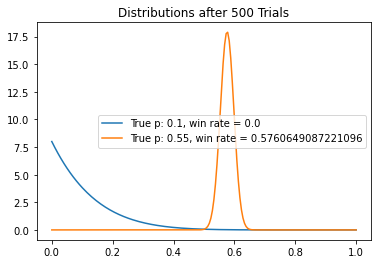

total reward earned: 556.0
overall win rate: 0.556
num times selected each bandit: [10, 990]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

# constants
true_proba = {'L':0.1,'R':0.55}
num_trials = 1000
trial_list = [50, 250, 500]

class BayesianBandit(object):
    def __init__(self, p, alpha = 1, beta = 1, N = 0):
        '''
        params:
            p (Float) : probability bounded between 0 and 1
            alpha (Float) : alpha of the beta distribution, default of 1
            beta (Float) : beta of the beta distribution, default of 1
            N (Integer) : tracks the number of trials, default of 0
        '''
        self.p = p
        self.alpha = alpha
        self.beta = beta
        self.N = N

    def simulate_action(self):
        '''
        This function will simulate the real world of users clicking or different versions of the website.
        '''
        return np.random.random() < self.p

    def sample(self):
        '''
        This function draws a sample from the beta distribution
        '''
        return np.random.beta(self.alpha, self.beta)

    def update(self, x):
        '''
        This function will update the alpha, beta and N for every iteration
        '''
        self.alpha += x
        self.beta += 1 - x
        self.N += 1

def plot(bandits, trial):
    '''
    This function will help visualize the distributions associated to each version
    of the website. It helps in compraison of which version is better.
    
    params:
        bandits (Object) : defined by the BayesianBandit class
        trial (Integer) : number of trials
    '''
    x = np.linspace(0, 1, 200)
    for b in bandits:
        true_prob = b.p
        win_rate = (b.alpha - 1) / b.N
        y = beta.pdf(x, b.alpha, b.beta)
        plt.plot(x, y, label="True p: {}, win rate = {}".format(true_prob, win_rate))
    plt.title("Distributions after {} Trials".format(trial))
    plt.legend()
    plt.show()
    
def experiment():
    bandits = [BayesianBandit(p) for p in list(true_proba.values())]
    
    rewards = np.zeros(num_trials)
    
    for i in range(num_trials):
        # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])

        if i in trial_list:
            plot(bandits, i)

        x = bandits[j].simulate_action()

        # update rewards
        rewards[i] = x

        # update the distribution
        bandits[j].update(x)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / num_trials)
    print("num times selected each bandit:", [b.N for b in bandits])

if __name__ == '__main__':
    experiment()

## Example 2 

In [2]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.animation as animation
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
sns.set()

In [3]:
real_probs_dict = {'L':0.1,'R':0.55}
assets = ['L','R']

In [4]:
'''
This function takes as input three tuples for alpha,beta that specify priorR,priorG 
And returns R,G along with the maximum value sampled from these three distributions.
We can sample from a beta distribution using scipy.
'''
def find_asset(priorR,priorG):    
    red_rv = scipy.stats.beta.rvs(priorR[0],priorR[1])
    green_rv = scipy.stats.beta.rvs(priorG[0],priorG[1])
    return assets[np.argmax([red_rv,green_rv])]


'''
This is a helper function that simulates the real world using the actual probability value of the assets.
In real life we won't have this function and our user click input will be the proxy for this function.
'''
def simulate_real_website(asset, real_probs_dict):
    #simulate a coin toss with probability. Asset clicked or not.
    if real_probs_dict[asset]> scipy.stats.uniform.rvs(0,1):
        return 1
    else:
        return 0

'''
This function takes as input the selected asset and returns the posteriors for the selected asset.
'''
def update_posterior(asset,priorR,priorG,outcome):
    if asset=='L':
        priorR=(priorR[0]+outcome,priorR[1]+1-outcome)
    elif asset=='R':
        priorG=(priorG[0]+outcome,priorG[1]+1-outcome)
    return priorR,priorG


'''
This function runs the strategy once.
'''
def run_strategy_once(priorR,priorG):
    # 1. get the asset
    asset = find_asset(priorR,priorG)
    # 2. get the outcome from the website/users
    outcome = simulate_real_website(asset, real_probs_dict)
    # 3. update prior based on outcome
    priorR,priorG = update_posterior(asset,priorR,priorG,outcome)
    return asset,priorR,priorG

In [5]:
priorR,priorG = (1,1),(1,1)
data = [("_",priorR,priorG)]
for i in range(50):
    asset,priorR,priorG = run_strategy_once(priorR,priorG)
    data.append((asset,priorR,priorG))

In [6]:
def plot_posteriors(priorR,priorG,ax=None,title=None):
    #fig = plt.figure(figsize=(12.5, 10))
    parameters = [priorR,priorG]
    x = np.linspace(0.001, 1, 150)
    colors = ['R', 'B']
    for i, (alpha, beta) in enumerate(parameters):
        color = colors[i]
        y = stats.beta.pdf(x, alpha, beta)
        lines = sns.lineplot(x, y, label="%s (%.1f,%.1f)" % (assets[i], alpha, beta), color = color,ax=ax)
        plt.fill_between(x, 0, y, alpha=0.3, color=color)
        if title:
            plt.title(title)
        plt.autoscale(tight=True)
    plt.legend(title=r"$\alpha, \beta$ - parameters")
    return plt

In [8]:
fig = plt.figure(figsize=(40, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
cnt=1
for i in range(0,30,2):
    ax = fig.add_subplot(8, 4, cnt)
    g = plot_posteriors(*data[i][1:],ax,"after "+str(i)+" runs")
    cnt+=1
plt.show()

In [9]:
counter_vals = Counter([x[0] for x in data[1:]])

In [10]:
counter_vals

Counter({'L': 6, 'R': 44})

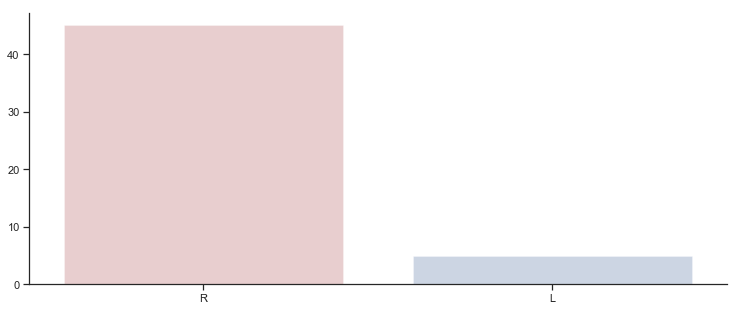

In [10]:
fig = plt.figure(figsize=(12.5, 5))
sns.set(style="ticks")
sns.barplot(x=list(counter_vals.keys()),y=list(counter_vals.values()),palette=['R','B'],alpha=0.3)
sns.despine()